In [1]:
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from alexnet import AlexNet
import numpy as np

In [2]:
# TODO: Load traffic signs data.

import pickle

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, Y_train = train['features'], train['labels']
X_test, Y_test = test['features'], test['labels']

In [3]:
def normalization(image):
    image = image.astype(np.float32)
    return image - np.mean(image)

X_train = [normalization(elem) for elem in X_train]
X_test = [normalization(elem) for elem in X_test]

In [4]:
nb_classes = len(np.unique(Y_train))

In [5]:
# TODO: Split data into training and validation sets.

from sklearn.model_selection import train_test_split
X_train_split, X_validation_split, Y_train_split, Y_validation_split = \
train_test_split(X_train, Y_train ,test_size=0.2, random_state=42 ,stratify=Y_train)

In [6]:
# TODO: Define placeholders and resize operation.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
resized = tf.image.resize_images(x, (227, 227))

y = tf.placeholder(tf.int32, (None))
y_one_hot = tf.one_hot(y, nb_classes)

In [7]:
# TODO: pass placeholder as first argument to `AlexNet`.
fc7 = AlexNet(resized, feature_extract=True)
# NOTE: `tf.stop_gradient` prevents the gradient from flowing backwards
# past this point, keeping the weights before and up to `fc7` frozen.
# This also makes training faster, less work to do!
fc7 = tf.stop_gradient(fc7)

In [8]:
# TODO: Add the final layer for traffic sign classification.
shape = (fc7.get_shape().as_list()[-1], nb_classes)  # use this shape for the weight matrix

fc8W = tf.Variable(tf.truncated_normal(shape))
fc8b = tf.Variable(tf.zeros(nb_classes))

logits = tf.matmul(fc7, fc8W)+fc8b

In [12]:
# TODO: Define loss, training, accuracy operations.
# HINT: Look back at your traffic signs project solution, you may
# be able to reuse some the code.

rate = 0.001
EPOCHS = 10
BATCH_SIZE = 64

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y_one_hot)
loss = tf.reduce_mean(cross_entropy)
training_operation = tf.train.AdamOptimizer(learning_rate=rate).minimize(loss)


init = tf.global_variables_initializer()

In [13]:
# TODO: Train and evaluate the feature extraction model.

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        
        if len(batch_x): # As BATCH_SIZE is not a divisor of X_train_split it raises an error if this is not checked
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
            total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [14]:
from sklearn.utils import shuffle

ls_training_accuracy = []
ls_validation_accuracy = []

num_examples = len(X_train_split)
total_batches = int(num_examples/BATCH_SIZE)

print("Training...")
print()

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(EPOCHS):
        X_t, Y_t = shuffle(X_train_split, Y_train_split)

        for num_batch, offset in enumerate(range(0, num_examples, BATCH_SIZE)):
            
            if num_batch % 50 == 0:
                print("Batch %d of %d" % (num_batch+1, total_batches))

            end = offset + BATCH_SIZE
            batch_x, batch_y = X_t[offset:end], Y_t[offset:end]

            if len(batch_x): # As BATCH_SIZE is not a divisor of X_train_split it raises an error if this is not checked
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        training_accuracy = evaluate(X_train_split, Y_train_split)
        validation_accuracy = evaluate(X_validation_split, Y_validation_split)

        ls_training_accuracy.append(training_accuracy)
        ls_validation_accuracy.append(validation_accuracy)

        print("\nEPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, 'alexnet_transferred_features')
    print("Model saved")

Training...

Batch 1 of 490
Batch 51 of 490
Batch 101 of 490
Batch 151 of 490
Batch 201 of 490
Batch 251 of 490
Batch 301 of 490
Batch 351 of 490
Batch 401 of 490
Batch 451 of 490

EPOCH 1 ...
Training Accuracy = 0.367
Validation Accuracy = 0.352

Batch 1 of 490
Batch 51 of 490
Batch 101 of 490
Batch 151 of 490
Batch 201 of 490
Batch 251 of 490
Batch 301 of 490
Batch 351 of 490
Batch 401 of 490
Batch 451 of 490

EPOCH 2 ...
Training Accuracy = 0.530
Validation Accuracy = 0.510

Batch 1 of 490
Batch 51 of 490
Batch 101 of 490
Batch 151 of 490
Batch 201 of 490
Batch 251 of 490
Batch 301 of 490
Batch 351 of 490
Batch 401 of 490
Batch 451 of 490

EPOCH 3 ...
Training Accuracy = 0.629
Validation Accuracy = 0.605

Batch 1 of 490
Batch 51 of 490
Batch 101 of 490
Batch 151 of 490
Batch 201 of 490
Batch 251 of 490
Batch 301 of 490
Batch 351 of 490
Batch 401 of 490
Batch 451 of 490

EPOCH 4 ...
Training Accuracy = 0.690
Validation Accuracy = 0.663

Batch 1 of 490
Batch 51 of 490
Batch 101 of 490

In [15]:
import pickle

history = {'train_acc': ls_training_accuracy, 'val_acc': ls_validation_accuracy}

with open("model_metrics.pkl", "wb") as fout:
    pickle.dump(history, fout)
    
print("Metrics saved")

Metrics saved


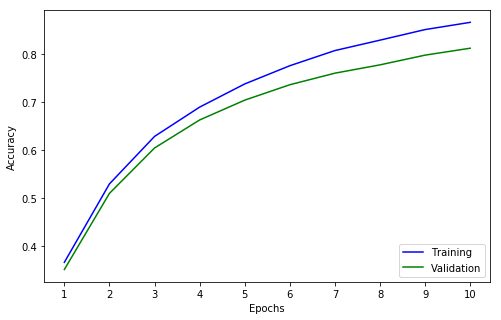

In [23]:
import warnings
warnings.filterwarnings('ignore') # Needs to be done as the fix for the warnings showed by plt.hold are not yet implemented

import pylab as plt
%matplotlib inline

plt.figure(figsize=(8,5))
plt.plot(range(1,len(ls_training_accuracy)+1), ls_training_accuracy, 'b')
plt.xticks(range(1,len(ls_training_accuracy)+1))
plt.hold(True)
plt.plot(range(1,len(ls_training_accuracy)+1), ls_validation_accuracy, 'g')
plt.hold(False)
_ = plt.legend(("Training", "Validation"), loc='lower right')
_ = plt.ylabel("Accuracy")
_ = plt.xlabel("Epochs")

```python
EPOCH 10 ...
Training Accuracy = 0.867
Validation Accuracy = 0.813
```
Told to be truth, the accuracy achieved by transfer learning using Alexnet & Imagenet is really low compared with what I achieved training the model from scratch with a LeNet-like architecture. I'm pretty sure that given the higher complexity of this model, It will easy surpass the previous model just by training more epochs (30 could be enough). But every epoch takes soooo sooo long. One epoch on GPU takes more than what takes to train the whole model used in the Traffic Sign Classifier Project with a CPU. Or there is something wrong, or at for this use-case doesn't compensate this approach.

In [24]:
# X_test is already normalized

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, Y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.640


:-(

I achieved 0.928 of accuracy on test in the Traffic Sign Classifier Project and 0.955 of accuracy on test in the Keras Lab